# <center> Projet GDELT </center> 

In [98]:
from pymongo import MongoClient
import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
import bokeh.palettes as palette
from bokeh.models import Range1d
import requests
import yaml
import seaborn as sns
from datetime import datetime
import calendar

output_notebook()
pd.options.display.max_rows = 999

Loading BokehJS ...

In [99]:
#Connect to mongodb
# client = MongoClient('mongodb://localhost:27017/')
client = MongoClient('mongodb://localhost:27020/', readPreference='primaryPreferred')

In [100]:
#Connect to spark db
db = client['gdelt']

## Importation des tables pour correspondance

### Table de correspondance des Events

In [12]:
# Import de la table
df_events = pd.read_csv("CAMEO_eventcodes.txt", sep="\t")
df_events.rename(columns={"CAMEOEVENTCODE":"EventCode"}, inplace=True)

### Table de correspondance des Pays (FIPS)

In [13]:
# Import de la table
df_countries = pd.read_csv("country_transco.csv", sep=";")
df_countries = df_countries.loc[:,["FIPS", "SHORT_NAME"]]
df_countries.rename(columns={"FIPS":"ActionGeo_CountryCode"}, inplace=True)

# Pour plot map world
countries = requests.get('https://rawgit.com/johan/world.geo.json/master/countries.geo.json').json()
countryObject = {}
for country in countries['features']:
    countryObject[country['properties']['name']] = {
        'x': [x[0] for x in country['geometry']['coordinates'][0]],
        'y': [x[1] for x in country['geometry']['coordinates'][0]],
    }
df_countries_map = pd.DataFrame(countryObject).transpose()
df_countries_map["SHORT_NAME"]=df_countries_map.index
df_countries = pd.merge(df_countries, df_countries_map, on='SHORT_NAME')

In [14]:
df_countries.head(5)

,ActionGeo_CountryCode,SHORT_NAME,x,y
0,AF,Afghanistan,"[61.210817, 62.230651, 62.984662, 63.193538, 6...","[35.650072, 35.270664, 35.404041, 35.857166, 3..."
1,AL,Albania,"[20.590247, 20.463175, 20.605182, 21.02004, 20...","[41.855404, 41.515089, 41.086226, 40.842727, 4..."
2,AG,Algeria,"[11.999506, 8.572893, 5.677566, 4.267419, 3.15...","[23.471668, 21.565661, 19.601207, 19.155265, 1..."
3,AO,Angola,"[[16.326528, -5.87747]]","[[16.57318, -6.622645]]"
4,AR,Argentina,"[[-65.5, -55.2]]","[[-66.45, -55.25]]"


## Requête 1 : le nombre d’articles/evenements pour chaque (jour, pays de l’evenement, langue de l’article)

In [65]:
# Collection spécialisée
mentions_events = db['query1']

In [67]:
# Requete 1
agg=mentions_events.aggregate([
   { "$match": 
        {"$and":[
            {"ActionGeo_CountryCode" : {"$exists" : 1}},
            {"MentionDocTranslationInfo" : {"$exists" : 1}},
            {"ActionGeo_CountryCode" : { "$ne": "null" }},
            {"MentionDocTranslationInfo" : { "$ne": "null" }},
        ]}
   },
#    {
#        "$group": {
#            "_id": {"annee": "$yearmention", "mois": "$monthmention", "jour": "$daymonthevent", "ActionGeo_CountryCode":"$ActionGeo_CountryCode", "langue":"$MentionDocTranslationInfo"},
#            "nb_articles": { "$sum": "$NumMentions" },
#        }
#    }
], allowDiskUse = True)

In [17]:
req1 = list(agg)

In [68]:
# list_id = list(map(lambda x: x['_id'], req1))
list_nb_articles = list(map(lambda x: {"nb_articles": x['nb_articles'], "yearmention" : x['yearmention'], "monthmention" : x['monthmention'], "daymonthevent" : x['daymonthevent'], "ActionGeo_CountryCode" : x['ActionGeo_CountryCode'], "langue": x['MentionDocTranslationInfo']}, req1))

df_1 = pd.DataFrame(list_nb_articles)

In [69]:
# Jointure avec la table des pays
df1_result = pd.merge(df_1, df_countries, on='ActionGeo_CountryCode')

In [70]:
def plot_news_volume(lang, country):
    plt.figure(figsize=(12,8))
    #sélection des articles dans la langue considérée, concernant le pays considéré:
    df = df1_result[df1_result["langue"]==lang]
    df = df[df["ActionGeo_CountryCode"]==country]
    df = df[(df["monthmention"]!=4) & (df["daymonthevent"]!=31)]
    df = df[(df["monthmention"]!=2) & (df["daymonthevent"]!=31)]

    #reconstitution d'un champ date complet et tri par ordre chronologique:
    df["date"] = df.apply(lambda row: pd.to_datetime(str(row['yearmention'])+'-'+str(row['monthmention'])+'-'+str(row['daymonthevent'])), axis=1)
    df = df.sort_values('date')

    #affichage du nombre d'articles par jour
    sns.set(style="darkgrid")
    plt.plot(df["date"],df["nb_articles"])
    plt.xlabel("date")
    plt.ylabel("nb of articles")
    plt.title("Number of articles about "+country+" in the news in "+lang)
    plt.show()


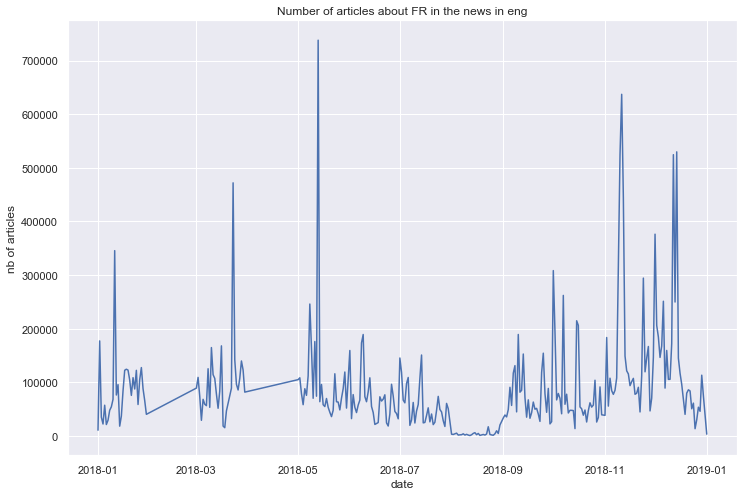

In [71]:
plot_news_volume('eng', 'FR')

## Requête 2 : pour un acteur(pays/organisation … ) ⇒ afficher les événement qui y font référence

In [72]:
# Collection spécialisée
mentions_events = db['query2']

In [73]:
# Choix de la requête
Nom_Acteur = "TOURIST"

In [74]:
# Requête 2
agg = mentions_events.aggregate( [
    
    { "$match":
        { "$or": [{"Actor1Name":Nom_Acteur},{"Actor2Name":Nom_Acteur}] },
    },
#     { "$group":
#         {"_id":
#             {"GLOBALEVENTID":"$GLOBALEVENTID",
#             "Actor1Name":"$Actor1Name",
#             "Actor2Name":"$Actor2Name",
#             "EventCode":"$EventCode",
#             "QuadClass":"$QuadClass",
#             "SQLDATE":"$SQLDATE",
#             "SOURCEURL":"$SOURCEURL"
#             }
#         }
#     }
], allowDiskUse = True );

In [25]:
# Récupération du résultat
req2 = list(agg)

In [75]:
# Mise en dataframe
list_id = list(map(lambda x: {"acteur1" : x['Actor1Name'], "acteur2": x['Actor2Name'],  "EventCode" : x["EventCode"], "QuadClass" : x["QuadClass"], "mois": x["daymonthevent"], "SOURCEURL": x["SOURCEURL"]}, req2))
df_2 = pd.DataFrame(list_id)
df_2["EventCode"]= df_2["EventCode"].apply(lambda x: int(x))

In [76]:
# Jointure avec la base CAMEO
df2_result = pd.merge(df_2, df_events, on='EventCode')

In [78]:
df2_result.head(10)

,EventCode,QuadClass,SOURCEURL,acteur1,acteur2,mois,EVENTDESCRIPTION
0,43,1,http://www.dw.com/en/costa-rica-plane-crashes-...,TOURIST,COSTA RICAN,1,Host a visit
1,43,1,https://www.pskov.kp.ru/daily/26776/3810864/,TOURIST,UKRAINE,1,Host a visit
2,43,1,http://redamf21.com/noticia?noti=80220,TOURIST,,2,Host a visit
3,43,1,http://nasional.republika.co.id/berita/nasiona...,TOURIST,CHINA,2,Host a visit
4,43,1,http://dominio.fm/obliga-inusual-nevada-a-cier...,TOURIST,,2,Host a visit
5,43,1,http://www.jornaldamidia.com.br/2018/01/03/mov...,TOURIST,BRAZIL,3,Host a visit
6,43,1,http://caracol.com.co/radio/2018/01/03/entrete...,TOURIST,URUGUAY,3,Host a visit
7,43,1,https://az.trend.az/azerbaijan/society/2843720...,TOURIST,AZERBAIJAN,4,Host a visit
8,43,1,http://lifestyle.liputan6.com/read/3214296/des...,TOURIST,,4,Host a visit
9,43,1,http://www.pressbox.co.uk/Business/Udaipur_Tra...,TOURIST,,4,Host a visit


## Requête 3 : les sujets (acteurs) qui ont eu le plus d’articles positifs/negatifs (mois, pays, langue de l’article)

In [79]:
# Collection spécialisée
mentions_events = db['query3']

In [80]:
# Requete 3
agg=mentions_events.aggregate([
    { "$match": 
        {"$and":[
            {"ActionGeo_CountryCode" : {"$exists" : 1}},
            {"MentionDocTranslationInfo" : {"$exists" : 1}},
            {"Actor1Code" : {"$exists" : 1}},
            {"ActionGeo_CountryCode" : { "$ne": "null" }},
            {"MentionDocTranslationInfo" : { "$ne": "null" }},
            {"Actor1Code" : { "$ne": "null" }},
            {"Actor1Code" : { "$ne": "" }}
            
        ]}
    },
#     {
#        "$project": {
#            "monthmention": 1, "ActionGeo_CountryCode": 1, "MentionDocTranslationInfo" : 1, "Actor1Code" : 1,
#            "lessThan0": { 
#                "$cond": [ { "$lt": ["AvgTone", 0 ] }, 1, 0]
#            },
#            "moreThan0": { 
#                "$cond": [ { "$gt": [ "AvgTone", 0 ] }, 1, 0]
#            }
           
#        }
#    },
#    {
#        "$group": {
#            "_id": {"monthmention": "$monthmention", "ActionGeo_CountryCode":"$ActionGeo_CountryCode", "langue":"$MentionDocTranslationInfo", "acteur":"$Actor1Code"},
#            "nb_articles_negatifs": { "$sum": "$lessThan0" },
#            "nb_articles_positifs": { "$sum": "$moreThan0" }
#        }
#    }
], allowDiskUse = True)


In [32]:
# Récupération de la réponse
req3 = list(agg)

In [81]:
# Mise sous data frame
list_nb_articles = list(map(lambda x:{'nb_articles_positifs': x['nb_articles_positifs'],'nb_articles_negatifs': x['nb_articles_negatifs'], 'ActionGeo_CountryCode': x['ActionGeo_CountryCode'], 'acteur': x['Actor1Code'], 'langue': x['MentionDocTranslationInfo'], 'mois': x["monthmention"]}, req3))
df_3 = pd.DataFrame(list_nb_articles)

In [82]:
# Jointure avec la table des pays
df3_result = pd.merge(df_3, df_countries, on='ActionGeo_CountryCode')

In [35]:
df3_result.head(5)

,ActionGeo_CountryCode,acteur,langue,mois,nb_articles_negatifs,nb_articles_positifs,SHORT_NAME,x,y
0,AE,AFG,eng,1,16,1,United Arab Emirates,"[51.579519, 51.757441, 51.794389, 52.577081, 5...","[24.245497, 24.294073, 24.019826, 24.177439, 2..."
1,AE,AFG,eng,2,8,9,United Arab Emirates,"[51.579519, 51.757441, 51.794389, 52.577081, 5...","[24.245497, 24.294073, 24.019826, 24.177439, 2..."
2,AE,AFG,eng,3,6,3,United Arab Emirates,"[51.579519, 51.757441, 51.794389, 52.577081, 5...","[24.245497, 24.294073, 24.019826, 24.177439, 2..."
3,AE,AFG,eng,4,40,21,United Arab Emirates,"[51.579519, 51.757441, 51.794389, 52.577081, 5...","[24.245497, 24.294073, 24.019826, 24.177439, 2..."
4,AE,AFG,eng,5,19,6,United Arab Emirates,"[51.579519, 51.757441, 51.794389, 52.577081, 5...","[24.245497, 24.294073, 24.019826, 24.177439, 2..."


In [83]:
#liste des principales langues
top10_langues = ['eng', 'spa', 'ara', 'fra', 'rus', 'mdr', 'hin', 'deu', 'tur', 'por']


def plot_pos_neg(lang, month): 

    #extraction des statistiques par langue et par mois
    df_lang = df3_result[df3_result['langue']==lang]
    df_lang = df_lang[df_lang['mois']==month]

    # on isole les 10 acteurs ayant le plus d'articles positifs
    n_actors = 10
    top_pos = df_lang.groupby('acteur').sum()
    top_pos = top_pos.sort_values('nb_articles_positifs', ascending=False)
    top_pos = top_pos['nb_articles_positifs'].iloc[:n_actors]

    #affichage du nombre d'article par acteur
    actors = top_pos.index.values
    y_pos = np.arange(1, n_actors+1)
    npos = top_pos.values
    plt.rcParams['figure.figsize'] = (10,5)
    pos_chart=plt.bar(y_pos,npos, color='g', alpha=0.5)
    plt.xlim(0, n_actors+1)
    plt.xticks(y_pos, actors)
    plt.xlabel('acteur')
    plt.ylabel('nb positive articles')
    plt.title('top 10 actors with positive mentions - month: '+str(month)+' - language: '+lang, size=15)
    plt.legend()
    plt.show()

    #meme procedure pour les articles negatifs
    # on isole les 10 acteurs ayant le plus d'articles negatifs
    top_neg = df_lang.groupby('acteur').sum()
    top_neg = top_neg.sort_values('nb_articles_negatifs', ascending=False)
    top_neg = top_neg['nb_articles_negatifs'].iloc[:n_actors]

    #affichage du nombre d'article par acteur
    actors = top_neg.index.values
    y_neg = np.arange(1, n_actors+1)
    nneg = top_neg.values
    neg_chart=plt.bar(y_neg,nneg, color='r', alpha=0.5)
    plt.xlim(0, n_actors+1)
    plt.xticks(y_neg, actors)
    plt.xlabel('acteur')
    plt.ylabel('nb negative mentions')
    plt.title('top 10 actors with negative mentions - month: '+str(month)+' - language: '+lang, size=15)
    plt.legend()
    plt.show()

No handles with labels found to put in legend.


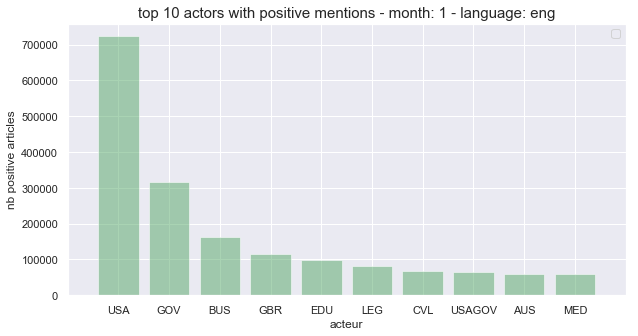

No handles with labels found to put in legend.


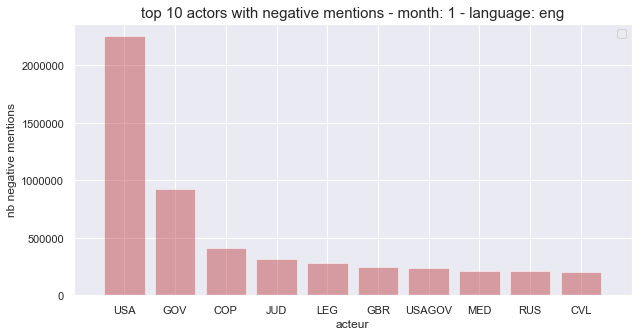

In [84]:
# Test sur la langue anglaise et le mois de janvier
plot_pos_neg('eng', 1)

## Requête 4 : Les acteurs/pays/organisations qui divisent le plus

In [85]:
# Collection spécialisée pour la requête 4
mentions_events = db['total_goldstein']

In [86]:
# Choix du paramètre pour la requête
Type_Actor = "ActionGeo_CountryCode" 

In [88]:
# Requete 4
agg = mentions_events.aggregate([
 { "$match": 
        {"$and":[
            {Type_Actor : {"$exists" : 1}},
            {Type_Actor : { "$ne": "null" }},
        ]}
 },
#  { "$group": {
#      "_id":   { "EventId": "$EventId", Type_Actor: "$"+Type_Actor },
#      "avgGoldstein": { "$avg": "$GoldsteinScale" } }  },
#  { "$group": {
#      "_id": { Type_Actor: "$_id." + Type_Actor },
#      "totalGoldstein": { "$sum": "$avgGoldstein"} }  },
{"$sort":{"totalGoldstein":1}}
], allowDiskUse = True)

In [45]:
# Récupération du résultat
req4 = list(agg)

In [89]:
# Mise en place du dataframe
list_id = list(map(lambda x: x['_id'], req4))
list_goldstein = list(map(lambda x: x['totalGoldstein'], req4))

df_4 = pd.DataFrame(list_id)
df_goldstein = pd.DataFrame(list_goldstein, columns=["Total_Goldstein"])
df_goldstein["Total_Goldstein_index"] = df_goldstein["Total_Goldstein"].apply(lambda x: int((x-np.min(df_goldstein["Total_Goldstein"]))//(0.2*(np.max(df_goldstein["Total_Goldstein"])-np.min(df_goldstein["Total_Goldstein"])))))
df_4 = pd.concat([df_goldstein, df_4], sort="False", axis=1)

In [90]:
# Jointure avec la table des pays
df4_result = pd.merge(df_4, df_countries, on='ActionGeo_CountryCode')

In [91]:
df4_result["SHORT_NAME"] = df4_result["SHORT_NAME"].apply(lambda x: str(x))

In [92]:
df4_result.head(5)

,Total_Goldstein,Total_Goldstein_index,ActionGeo_CountryCode,SHORT_NAME,x,y
0,-1392338.6,0,SY,Syria,"[38.792341, 36.834062, 35.719918, 35.700798, 3...","[33.378686, 32.312938, 32.709192, 32.716014, 3..."
1,-1051379.3,0,IS,Israel,"[35.719918, 35.545665, 35.18393, 34.974641, 35...","[32.709192, 32.393992, 32.532511, 31.866582, 3..."
2,-530341.4,0,AF,Afghanistan,"[61.210817, 62.230651, 62.984662, 63.193538, 6...","[35.650072, 35.270664, 35.404041, 35.857166, 3..."
3,-379502.6,0,YM,Yemen,"[53.108573, 52.385206, 52.191729, 52.168165, 5...","[16.651051, 16.382411, 15.938433, 15.59742, 15..."
4,-182381.2,0,PK,Pakistan,"[75.158028, 75.896897, 76.192848, 77.837451, 7...","[37.133031, 36.666806, 35.898403, 35.49401, 34..."


In [93]:
# Plot Map
p = figure(
    width = 900, 
    height= 550, 
    title='World Countries', 
    x_axis_label='Longitude',
    y_axis_label='Latitude',
)
list_color = ["#b62020","#cb2424" ,"#fe2e2e", "#fe5757", "#fe8181"]
for country in df4_result.SHORT_NAME:
    index_color = df4_result[df4_result["SHORT_NAME"]==country].loc[:, "Total_Goldstein_index"].tolist()[0]
    p.patch(
        x = df_countries_map[df_countries_map["SHORT_NAME"]==country].loc[:, "x"].tolist()[0],
        y = df_countries_map[df_countries_map["SHORT_NAME"]==country].loc[:, "y"].tolist()[0],  
        color = list_color[index_color],
        alpha =  1
    )
p.xgrid.visible = False
p.ygrid.visible = False
p.x_range = Range1d(start = -180, end = 140)
p.y_range = Range1d(start = -50, end = 90)
show(p)

## Requête supplémentaire : Étudier l'évolution de la relation entre deux pays au cours du temps

### Mise en œuvre

On cherche à comprendre comment évolue la relation d'un pays avec un autre au cours du temps. Pour ce faire, on défini un "score de relation" comme suit : 
* On cherche dans la base de données l'ensemble des articles traitant de l'action de l'acteur 1 sur l'acteur 2
* On récupère le Goldstein Scale de ces articles
* On en fait la moyenne.

Ceci nous donne le score de la relation de l'acteur 1 sur l'acteur 2.  
Poure montrer l'asymétrie de ces relations, on fait de même mais au lieu de chercher les articles taritant de l'action de l'acteur 1 sur l'acteur 2, on cherche ceux traitant de l'action de l'acteur 2 sur l'acteur 1 et on en déduit le score.

In [94]:
#Définition d ela collection utilisée
events = db.query5

### Création des fonctions utile pour le calcul du score de relation

In [52]:
#Définition d'une fonction qui calcule le score de relation sur un mois
'''
def compute_score_for_month(actor_1_code,actor_2_code,month,year):
    '''Computes the relationship score between two actors
    
    Parameters 
    ----------
    actor_1_code : String, the code of the first actor
    actor_2_Code : String, the code of the other actor
    month : String, the month in which the score is to be calculated
    year : String, default: 2018, the year in which the score is to be calculated
    
    Returns 
    ----------
    actor_1_score : float, the relationship score for the first actor
    actor_2_score : float, the relationship score for the second actor
    '''
    actor_1_score = []
    actor_2_score = []
    agg = events.find({
             '$or':[
                 {'$and':[{"Actor1Geo_CountryCode":actor_1_code},{"Actor2Geo_CountryCode":actor_2_code},{"MonthYear": int(year + month)}]},
                 {'$and':[{"Actor1Geo_CountryCode":actor_2_code},{"Actor2Geo_CountryCode":actor_1_code},{"MonthYear": int(year + month)}]}
             ]
         })
'''
    agg = events.aggregate([
        {'$match':
         {
             '$or':[
                 {'$and':[{"Actor1Geo_CountryCode":actor_1_code},{"Actor2Geo_CountryCode":actor_2_code},{"MonthYear": int(year + month)}]},
                 {'$and':[{"Actor1Geo_CountryCode":actor_2_code},{"Actor2Geo_CountryCode":actor_1_code},{"MonthYear": int(year + month)}]}
             ]
         }
        },
        {'$limit':1000000},
        {'$sort': {"actor":1}},
        {'$group': {
            '_id': {"Actor1Geo_CountryCode":'$Actor1Geo_CountryCode',"Actor2Geo_CountryCode":"$Actor2Geo_CountryCode"},
           "avgGoldstein": "$avgGoldsteinScale"
        }
        }
    ]
    )
    '''
    agg = events.find({
             '$or':[
                 {'$and':[{"Actor1Geo_CountryCode":actor_1_code},{"Actor2Geo_CountryCode":actor_2_code},{"MonthYear": int(year + month)}]},
                 {'$and':[{"Actor1Geo_CountryCode":actor_2_code},{"Actor2Geo_CountryCode":actor_1_code},{"MonthYear": int(year + month)}]}
             ]
         })
    
    return list(agg)
    '''

SyntaxError: invalid syntax (<ipython-input-52-72fae6007575>, line 4)

In [95]:
def compute_score_for_month(actor_1_code,actor_2_code,month,year):
    agg = events.find({
             '$or':[
                 {'$and':[{"Actor1Geo_CountryCode":actor_1_code},{"Actor2Geo_CountryCode":actor_2_code},{"MonthYear": int(year + month)}]},
                 {'$and':[{"Actor1Geo_CountryCode":actor_2_code},{"Actor2Geo_CountryCode":actor_1_code},{"MonthYear": int(year + month)}]}
             ]
         })
    return list(agg)

In [96]:
def plot_relationship(actor_1_code,actor_2_code,year = '2018'):
    '''Plots the relationship evolution of 2 actors over a year
    
    Parameters
    ----------
    actor_1_code : String, the code of the first actor
    actor_2_Code : String, the code of the other actor
    year : String, default: 2018, the year in which the score is to be calculated

    '''
    month_list = ['01','02','03','04','05','06','07','08','09','10','11','12']
    months_name = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]

    scores_actor_1 = []
    scores_actor_2 = []
    for month in month_list:
        req = compute_score_for_month(actor_1_code,actor_2_code,month,year)
        score_actor_1 = req[0]['avgGoldsteinScale']
        score_actor_2 = req[1]['avgGoldsteinScale']
        scores_actor_1.append(score_actor_1)
        scores_actor_2.append(score_actor_2)
    plt.figure(figsize=(10,8))
    plt.plot(months_name,scores_actor_1,label=actor_1_code + '->' + actor_2_code)
    plt.plot(months_name,scores_actor_2,label=actor_2_code + '->' + actor_1_code)
    plt.legend(loc='best')
    plt.title('Relationship between ' + actor_1_code + ' and ' + actor_2_code)
    plt.ylabel('score')
    plt.show()

### Un exemple : l'évolution de la relation entre la France et la Belgique pour l'année 2018

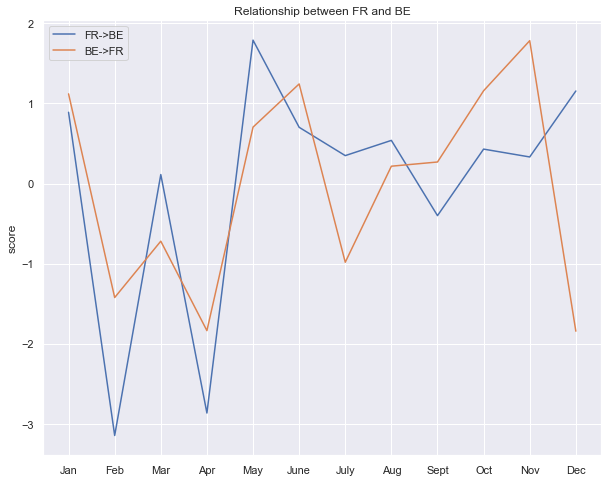

Wall time: 460 ms


In [97]:
%time plot_relationship('FR','BE')